In [144]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import copy
from tqdm import tqdm

In [145]:
class Layer:
    
    
    def __init__(self,NC,NN,ActFun,rate=0.1): # Jugar con la tasa de mutacion
        
        self.NC = NC
        self.NN = NN
        self.ActFunc = ActFun
        self.rate = rate
        
        self.W = np.random.uniform( -10.,10.,(self.NC,self.NN) )
        self.b = np.random.uniform( -10.,10.,(1,self.NN) )
        
    def Activation(self,x):
        z = np.dot(x,self.W) + self.b
        return self.ActFunc( z )[0]
    
    def Mutate(self):
    
        #self.W += np.random.normal( loc=0., scale=self.rate, size=(self.NC,self.NN))
        #self.b += np.random.normal( loc=0., scale=self.rate, size=(1,self.NN))
        
        self.W += np.random.uniform( -self.rate, self.rate, size=(self.NC,self.NN))
        self.b += np.random.uniform( -self.rate, self.rate, size=(1,self.NN))

In [146]:
sigm = lambda x: 1/(1+np.exp(-x))

def GetBrain(mutRate):
    l0 = Layer(1,5,sigm,mutRate)
    l1 = Layer(5,1,sigm,mutRate)
    Brain = [l0,l1]
    return Brain 

In [147]:
class Robot:
    
    def __init__(self, dt, Layers, Id=0):
        
        self.Id = Id
        self.dt = dt
        
         #
        self.r = np.random.uniform([0.,0.])
        theta = 0.
        self.v = np.array([1.*np.cos(theta),1.*np.sin(theta)])
        self.previousChanges = 0 
        self.ignore = True
        
        # Capacidad o aptitud del individuo
        self.Fitness = np.inf
        self.Steps = 0

        # Brain
        self.Layers = Layers
        
    def GetR(self):
        return self.r
    
    def Evolution(self):
        self.r += self.v*self.dt # Euler integration (Metodos 2)

        # Cada generación regresamos el robot al origin
        # Y volvemos a estimar su fitness
    def Reset(self):
        self.Steps = 0.
        self.r = np.array([0.,0.])
        self.Fitness = np.inf    
        
    # Aca debes definir que es mejorar en tu proceso evolutivo
    def SetFitness(self):
        self.Fitness = 1/(self.Steps)
        
       # Brain stuff
    def BrainActivation(self,x,threshold=0.7): 
        # El umbral (threshold) cerebral es a tu gusto!
        # cercano a 1 es exigente
        # cercano a 0 es sindrome de down
        
        # Forward pass - la infomación fluye por el modelo hacia adelante
        for i in range(len(self.Layers)):         
            if i == 0:
                output = self.Layers[i].Activation(x)
            else:
                output = self.Layers[i].Activation(output)
        
        self.Activation = np.round(output,4)
        
        # Cambiamos el avance del robot en la región de interés
        if x <= 1 and x >= -1:
            self.Steps += 1
        
        # Cambiamos el vector velocidad
        if self.Activation[0] > threshold:
            self.previousChanges += 1
            self.v = -self.v
        
        #Tiene en cuenta una ventana de 4 momentos anteriores
        #para penalizar por activación en el momento incorrecto
        if self.previousChanges != 1 and self.previousChanges%2 != 0:
            if not self.ignore:
                self.Steps = self.Steps*0.9
            else: 
                self.ignore = False
        
        self.previousChanges = self.previousChanges<<1
        
        if self.previousChanges > 1<<19:
            self.previousChanges -= 1<<19
        
        return self.Activation
    
    # Aca mutamos (cambiar de parametros) para poder "aprender"
    def Mutate(self):
        for i in range(len(self.Layers)):
            self.Layers[i].Mutate()
    
    # Devolvemos la red neuronal ya entrenada
    def GetBrain(self):
        return self.Layers

In [148]:
def GetRobots(N, dt, mutRate):
    
    Robots = []
    
    for i in range(N):
        
        Brain = GetBrain(mutRate)
        r = Robot(dt,Brain,Id=i)
        Robots.append(r)
        
    return Robots

In [149]:
def GetPlot():
    
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,2,1)
    ax1 = fig.add_subplot(1,2,2)
    
    ax.set_xlim(-1.,1.)
    ax.set_ylim(-1.,1.)
 
    return ax,ax1

# Time Evolution

In [150]:
def TimeEvolution(Robots,e,Plot=False):
    
  
    for it in range(t.shape[0]):
        
        if Plot:
        
            clear_output(wait=True)
        
            ax,ax1 = GetPlot()
            ax1.set_ylim(0.,1.)
        
            ax.set_title('t = {:.3f}'.format(t[it]))
        
        Activation = np.zeros(len(Robots))
        
        for i,p in enumerate(Robots):
            p.Evolution()
         
            # Activacion cerebral
            Act = p.BrainActivation(p.GetR()[0])
            Activation[i] = Act
            # Region donde aumentamos los pasos para el fitness
            
                
            if Plot and i < 5: # Solo pintamos los primeros 5, por tiempo de computo
                ax.scatter(p.r[0],p.r[1],label='Id: {}, Steps: {:.0f}'.format(p.Id,p.Steps))
                ax.quiver(p.r[0],p.r[1],p.v[0],p.v[1])
                
        # Pintamos la activaciones de los primeros 5
        
        if Plot:
            ax1.plot(np.arange(0,len(Robots[:5]),1),Activation[:5],marker='o',color='b',label='Activation')
            ax1.axhline(y=0.7,color='r')
        
        if Plot:
        
            ax.legend(loc=0)  
            ax1.legend(loc=0)
            plt.show()
            time.sleep(0.001)

# Algoritmo evolutivo

In [151]:
# Definimos la rutina de entrenamiento
def Genetic(Robots, epochs = 200, Plot = True, Plottime=False):
    
    # Porcentaje de robots elegidos en cada epoch
    N = int(0.7*len(Robots))
    
    FitVector = np.array([])
    
    
    x = np.linspace(-1,1,20)
    Act = np.zeros_like(x)
    
    for e in range(int(epochs)):
        
        # Reiniciamos y mutamos los pesos
        
        for p in Robots:
            p.Reset() 
            p.Mutate()
            
        # Evolucionamos
        TimeEvolution(Robots,e,Plottime) # Apagar dibujar la evolución para entrenar
        
        # Actualizamos fitness de cada robot
        for i,p in enumerate(Robots):
            p.SetFitness()
        
        # Aca va toda la rutina de ordenar los bots del más apto al menos apto
        # Elegir los más aptos
        scores = [(p.Fitness,p) for p in Robots]
        scores.sort(key = lambda x: x[0], reverse = False)
        
        # Guardamos el mejor fitness y le mejor robot
        best_fitness = scores[0][0]
        best_bot = scores[0][1]
        
        FitVector = np.append(FitVector,best_fitness)
        
        for i in range(len(x)):
            Act[i] = best_bot.BrainActivation(x[i])
        
        clear_output(wait=True)
        
        print('Epoch:', e)
                
        # Last fitness
        print('Last Fitness:', FitVector[-1])
        
        
        if Plot:
            
            ax,ax1 = GetPlot()
            ax.plot(x,Act,color='k')
            ax.set_ylim(0.,1)
            ax.axhline(y=0.75,ls='--',color='r',label='Threshold')
            
            ax1.set_title('Fitness')
            ax1.plot(FitVector)
        
            ax.legend(loc=0)
            
            plt.show()
            
            time.sleep(0.01)
        
    Brain = best_bot.Layers
    l0, l1 = Brain
    print("\nCapa Inicial")
    print("-"*20+"W"+"-"*20)
    print(l0.W)
    print("-"*20+"b"+"-"*20)
    print(l0.b)
    print("Capa Oculta")
    print("-"*20+"W"+"-"*20)
    print(l1.W)
    print("-"*20+"b"+"-"*20)
    print(l1.b)   
    
    return best_bot, FitVector

In [152]:
#a), b)
dt = 0.1
t = np.arange(0.,5.,dt)
mutRate = 0.1
Robots = GetRobots(200, dt, mutRate)

In [153]:
#c)
#Se realiza con la función GetBrain() a la cual se llama en la clase Robot
#d) 
#Se realiza en la clase Robot, a partir del atributo self.Steps inicilizado 
#en 0. Sobre este se adiciona 1 si está en el rango -1 <= x <= 1, y se penaliza
#en un factor de 0.0 a 0.9 de forma aleatoria si está por fuera
#e)
#Se realiza en la clase Robot, a partir de la función llamada SetFitness
#f)
#Se realiza en la clase Layer a partir del valor rate. Se han modificado las 
#funciones GetBrain() y GetRobots() para brindar una tasa de mutación distinta
#g)
#La función BrainActivation de la clase Robot se encarga de hacer el forward
#pass de la red

Epoch: 199
Last Fitness: 0.02441942809699397


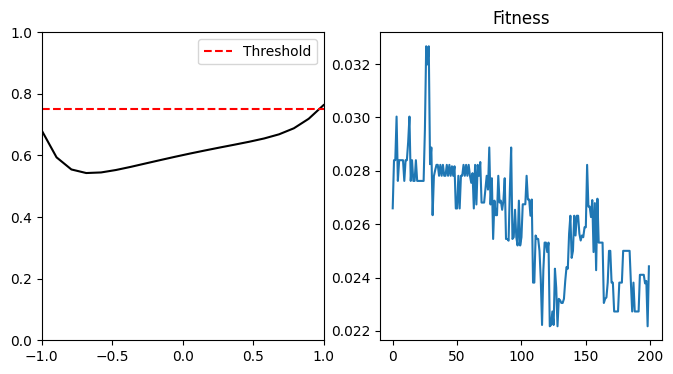


Capa Inicial
--------------------W--------------------
[[ 8.06237232 -4.16444544 -4.16694878  7.44714334  0.55114703]]
--------------------b--------------------
[[ -8.80186219  -9.48654872 -10.53361268   9.47000424   1.88978355]]
Capa Oculta
--------------------W--------------------
[[ 1.3225193 ]
 [-5.02627856]
 [-5.84286187]
 [-7.5722478 ]
 [ 6.54196498]]
--------------------b--------------------
[[2.2990499]]


In [154]:
Best, FitVector = Genetic(Robots, Plot=True, Plottime = False) # Apagar Plottime para el entrenamiento

In [162]:
Brain = Best.Layers
l0, l1 = Brain
print("Capa Inicial")
print("-"*20+"W"+"-"*20)
print(l0.W)
print("-"*20+"b"+"-"*20)
print(l0.b)
print("Capa Oculta")
print("-"*20+"W"+"-"*20)
print(l1.W)
print("-"*20+"b"+"-"*20)
print(l1.b)

Capa Inicial
--------------------W--------------------
[[ 8.06237232 -4.16444544 -4.16694878  7.44714334  0.55114703]]
--------------------b--------------------
[[ -8.80186219  -9.48654872 -10.53361268   9.47000424   1.88978355]]
Capa Oculta
--------------------W--------------------
[[ 1.3225193 ]
 [-5.02627856]
 [-5.84286187]
 [-7.5722478 ]
 [ 6.54196498]]
--------------------b--------------------
[[2.2990499]]


# Parámetros del modelo ganador

### Capa Inicial

\begin{equation*}
W = \begin{pmatrix}8.06237232 & -4.16444544 & -4.16694878 & 7.44714334 & 0.55114703 \\ 
\end{pmatrix}
\end{equation*}

\begin{equation*}
b = \begin{pmatrix}-8.80186219  & -9.48654872 & -10.53361268 &  9.47000424 &  1.88978355 \\
\end{pmatrix} 
\end{equation*}

### Capa Oculta

\begin{equation*}
W = \begin{pmatrix}  1.3225193 \\
 -5.02627856\\
 -5.84286187\\
 -7.5722478 \\
  6.54196498\\\end{pmatrix}
\end{equation*}

\begin{equation*}
b = \begin{pmatrix}2.2990499 \\
    \end{pmatrix}
\end{equation*}

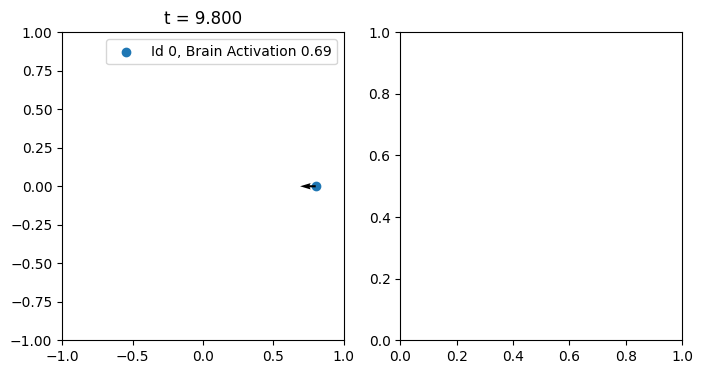

In [174]:
#Testing robot
dt = 0.2
t = np.arange(0.,10.0,dt)
mutRate = 0.1
Brain = GetBrain(mutRate)
Brain[0].W = [[ 8.06237232, -4.16444544, -4.16694878, 7.44714334, 0.55114703]]
Brain[0].b = [[ -8.80186219,  -9.48654872, -10.53361268, 9.47000424, 1.88978355]]
Brain[1].W = [[ 1.3225193 ],[-5.02627856],[-5.84286187],[-7.5722478 ],[ 6.54196498]]
Brain[1].b = [[2.2990499]]
R = Robot(dt,Brain,0)
R.Reset()
for it in range(t.shape[0]):
    clear_output(wait=True)

    R.Evolution()
    # Brain activation
    A = R.BrainActivation(R.GetR()[0])

    ax,_ = GetPlot()
    ax.set_title('t = {:.3f}'.format(t[it]))

    ax.scatter(R.r[0], R.r[1], label='Id {}, Brain Activation {:.2f}'.format(R.Id,A[0]))
    ax.quiver(R.r[0], R.r[1], R.v[0], R.v[1])

    ax.legend()
    plt.show()

    time.sleep(0.01)